In [1]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
import tensorflow as tf
import os

In [2]:
local_weight_file = './pretrained/efficientnetb1_notop.h5'

# Set the input shape and remove the dense layers.
pre_trained_model = EfficientNetB1(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

In [3]:
# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weight_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [5]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('input_12')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  [(None, 150, 150, 3)]


In [6]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.4)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 1024)              69121024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 69,122,049
Trainable params: 69,122,049
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Set the training parameters
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [8]:
base_dir = '../Dataset/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training redness pictures
train_redness_dir = os.path.join(train_dir, 'redness') 

# Directory with training normal pictures
train_normal_dir = os.path.join(train_dir, 'normal') 

# Directory with validation redness pictures
validation_redness_dir = os.path.join(validation_dir, 'redness') 

# Directory with validation normal pictures
validation_normal_dir = os.path.join(validation_dir, 'normal')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=['redness', 'normal'],
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         classes=['redness', 'normal'],
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 957 images belonging to 2 classes.
Found 89 images belonging to 2 classes.


In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:
            print("\n Cancelling training")
            self.model.stop_training = True

In [10]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 50,
            callbacks=[callbacks]
            )

Epoch 1/50
10/10 - 14s - loss: 5.7247 - accuracy: 0.7750 - val_loss: 9.3475 - val_accuracy: 0.4250 - 14s/epoch - 1s/step
Epoch 2/50


: 

: 

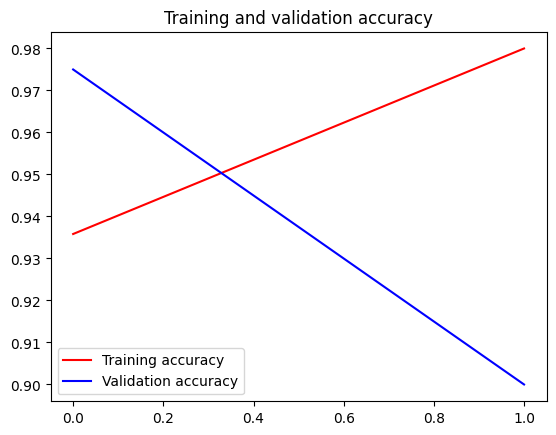

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [36]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
# from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

root = tk.Tk()
root.withdraw()
uploaded = filedialog.askopenfilename()
 
  # predicting images
path = uploaded
img = load_img(path, target_size=(224, 224))
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes[0])
    
if classes[0]>0.5:
  print("noredness")
else:
  print("redness")
 

1/1 [==============================] - 0s 41ms/step
[0.68120545]
 noredness
